In [1]:
from importlib import reload
import numpy as np
import os
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import tensorflow as tf

In [63]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

<module 'src.ml_classes' from 'C:\\Users\\Andrew\\Documents\\mlprojects\\781-piano-autoencoder\\src\\ml_classes.py'>

In [41]:
# two ways of transposing if they are integers indicating pitch, but dimensions are unknown
int_transpose = np.vectorize(lambda x: min(max(x + semitones, 0), 87))
def int_transpose1():
    semitones = 2
    b = np.array([[1,2,3],[3,4,5]])
    b = int_transpose(b)

# or like this:
def int_transpose2():
    semitones = 2
    b = np.array([[1,2,3],[3,4,5]])
    for idx,value in np.ndenumerate(b):
        b[idx] = min(max(value + semitones, 0), 87)
    
print(timeit.timeit(int_transpose1, number=10000))
print(timeit.timeit(int_transpose2, number=10000))

0.26732860000265646
0.14455119999911403


In [112]:
with open('H2', 'wb') as f:
    pickle.dump(H, f)

In [72]:
# and back to pretty midi...
def H2pm(H, O, V, tempo, sub_beat_times):
    beat_length = 60 / tempo
    sub_beat_length = beat_length / sub_beats
    pm = pretty_midi.PrettyMIDI(resolution=960, tempo=tempo)
    pm.instruments.append(pretty_midi.Instrument(0, name='piano'))
    for timestep in range(len(H)):
        for pitch in H(timestep):
            noteM = pretty_midi.Note(64, pitch + 21, sub_beat_times[timestep], end)
            pm.instruments[0].notes.append(noteM)

In [ ]:
dg = ml_classes.ModelDataGenerator(model_datas, ['H', 'tempo', 'key'], ['H', 'V'], batch_size = 4, seq_length=seq_length)
dg.__getitem__(2)

In [98]:
m = np.zeros((64,88)
sys.getsizeof(m)/1024/1024 * 5*60*10 # 5 training examplems per minute

129.2266845703125

In [105]:
sys.getsizeof(H)/1024/1024 * 5*60*10 # 5 training examplems per minute

0.54931640625

In [120]:
sys.getsizeof(np.zeros((3,128,64,88), dtype=np.int64))/1024

16896.140625

In [68]:
model_datas = data.folder2examples('training_data\midi_files', sparse=False)

 
<DirEntry 'aa_97_Cm.mid'>
examples: 16
sub beats per example: 64
no. of sub beats: 1024
 
<DirEntry 'ab_108_Eb.mid'>
examples: 9
sub beats per example: 64
no. of sub beats: 576
 
<DirEntry 'ac_82_Ebm.mid'>
examples: 16
sub beats per example: 64
no. of sub beats: 1024
 
<DirEntry 'ad_63_Am.mid'>
examples: 14
sub beats per example: 64
no. of sub beats: 896
 
<DirEntry 'ae_78_Am.mid'>
examples: 35
sub beats per example: 64
no. of sub beats: 2240
 
<DirEntry 'af_94_Bm.mid'>
examples: 27
sub beats per example: 64
no. of sub beats: 1728
 
<DirEntry 'ag_65_Gm.mid'>
examples: 17
sub beats per example: 64
no. of sub beats: 1088
 
<DirEntry 'ah_104_Bm.mid'>
examples: 12
sub beats per example: 64
no. of sub beats: 768
 
<DirEntry 'ai_79_D.mid'>
examples: 14
sub beats per example: 64
no. of sub beats: 896
 
<DirEntry 'aj_107_Em.mid'>
examples: 6
sub beats per example: 64
no. of sub beats: 384
 
<DirEntry 'ak_107_Ebm.mid'>
examples: 77
sub beats per example: 64
no. of sub beats: 4928
 
<DirEntry 

In [65]:
n_notes=88
model_input = namedtuple('input', 'name dim')
model_output = namedtuple('output', 'name dim activation')

H_in = model_input('H', n_notes)
tempo_in = model_input('tempo', 1)
key_in = model_input('key', 12)

H_out = model_output('H', n_notes, 'sigmoid')
O_out = model_output('O', n_notes, 'tanh')
V_out = model_output('V', n_notes, 'sigmoid')

In [66]:
seq_length = 64
seq_inputs = [H_in]
aux_inputs = [tempo_in, key_in]

seq_inputs = [tf.keras.Input(shape=(seq_length,seq_in.dim), name=seq_in.name + '_in') for seq_in in seq_inputs]
aux_inputs = [tf.keras.Input(shape=(aux_in.dim,), name=aux_in.name + '_in') for aux_in in aux_inputs]

z = models.create_LSTMencoder(seq_inputs, aux_inputs, seq_length=seq_length, lstm_layers = 2, dense_layers = 2, hidden_state_size = 16, latent_size = 16,
                    dense_size = 16)
outputs = models.create_LSTMdecoder(z, [H_out, V_out], seq_length=seq_length, hidden_state_size = 16,
                    dense_size = 16)
model = tf.keras.Model(inputs=[seq_inputs + aux_inputs], outputs=outputs, name=f'autoencoder')
model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tempo_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
key_in (InputLayer)             [(None, 12)]         0                                            
__________________________________________________________________________________________________
H_in (InputLayer)               [(None, 64, 88)]     0                                            
__________________________________________________________________________________________________
repeat64Times (RepeatVector)    multiple             0           tempo_in[0][0]                   
                                                                 key_in[0][0]           

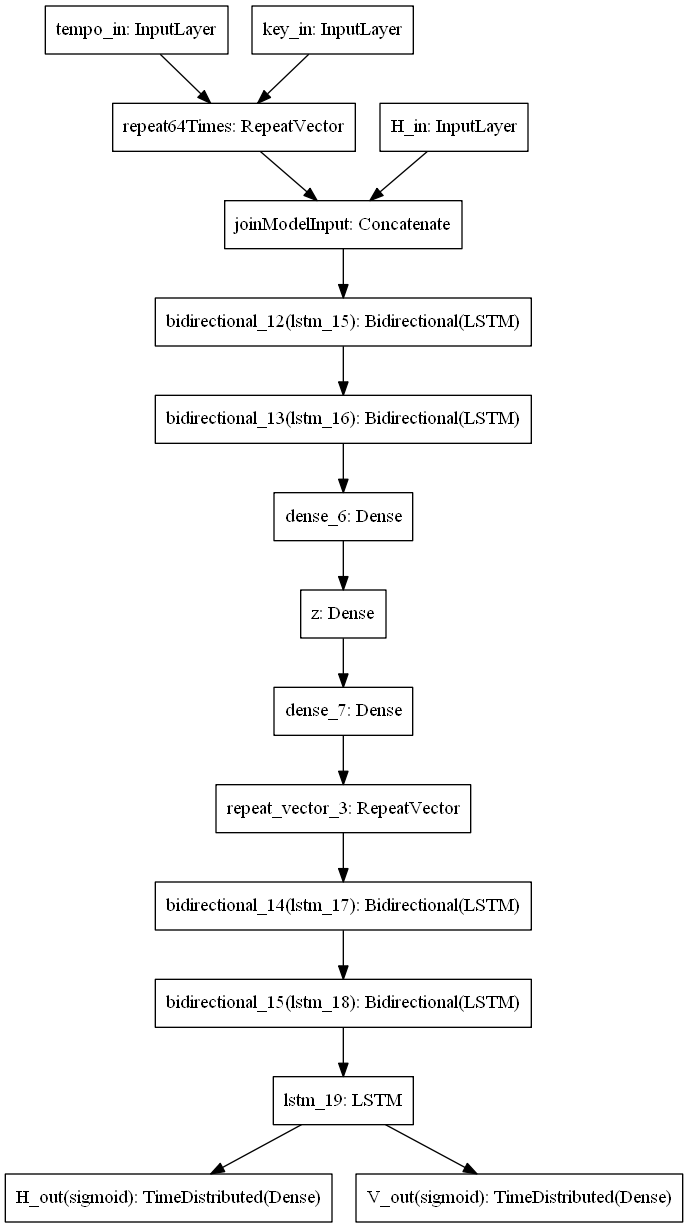

In [52]:
tf.keras.utils.plot_model(model)

In [ ]:
dg = ml_classes.ModelDataGenerator(model_datas, ['H', 'tempo', 'key'], ['H', 'V'], batch_size = 4, seq_length=seq_length)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# fit the model
# key is not working.
history = model.fit_generator(dg, epochs=3, verbose=1)
# model.fit([model_datas2['H'], model_datas['tempo']],[model_datas['H'], model_datas['V']], epochs=3)


In [43]:
# if model_datas aren't sparse, then this works 
model_datas2 = {md.name + '_in': md.data for md in model_datas}
model_datas2.update({md.name + '_out': md.data for md in model_datas})
model.fit(model_datas2, model_datas2, epochs=30)

In [62]:
tuple([2])

(2,)